# Deep Learning SIGN LANGUAGE PROJECT


“Our project is a Deep Learning-based Multi-Class Image Classification model for American Sign Language hand gestures, built using CNN Transfer Learning (EfficientNetB0).”




---









1) Copy the ZIP file from Google Drive

In [ ]:
!cp "/content/drive/MyDrive/Sign Language recognition.v1i.folder.zip" "/content/"


2) Unzip the dataset into a dedicated folder

In [ ]:
!unzip -q "/content/Sign Language recognition.v1i.folder.zip" -d "/content/dataset"


3) List the extracted files

In [ ]:
!ls /content/dataset


README.dataset.txt  README.roboflow.txt  test  train  valid




---



# 1-Imports, Configuration, and Directory Setup

This cell initializes the essential components required for the project. It begins by importing TensorFlow and Keras, which provide the tools for building and training the deep-learning model. The os module is imported to help manage directory paths for the dataset.

Next, the base directory for the dataset is defined (/content/dataset). The image dimensions (224×224) are set to match the input size expected by EfficientNetB0, and the batch size is configured for training efficiency.

The cell then constructs full paths for the training, validation, and testing datasets by combining the base directory with the corresponding subfolder names. Finally, it prints these paths to confirm that they were generated correctly.

Output Explanation

The output displays three lines showing the paths for the training, validation, and test folders. This ensures that the dataset structure is recognized properly before proceeding to data loading.

In [ ]:
# ===== Cell 1: Imports + Paths & basic config =====

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import os

data_dir = "/content/dataset"

img_height = 224
img_width = 224
batch_size = 32

train_dir = os.path.join(data_dir, "train")
val_dir   = os.path.join(data_dir, "valid")
test_dir  = os.path.join(data_dir, "test")

print("Train dir:", train_dir)
print("Val dir:", val_dir)
print("Test dir:", test_dir)


Train dir: /content/dataset/train
Val dir: /content/dataset/valid
Test dir: /content/dataset/test




---



# 2-Dataset Loading (Train / Validation / Test)

This cell is responsible for loading the image dataset from the directory structure and preparing it for training, validation, and testing. The image_dataset_from_directory function from Keras automatically handles several preprocessing steps, including label assignment, image resizing, batching, and shuffling.

Three datasets are created:

train_ds: Loads images from the training folder, resizes them to 224×224 pixels, applies categorical labels, and batches them.

val_ds: Loads the validation set using the same configuration as the training set.

test_ds: Loads the test set with shuffling disabled to keep the order consistent during evaluation.

After loading the datasets, class names are extracted directly from the training directory. The code prints the class labels and the total number of classes (29), confirming that the dataset was correctly recognized.

To improve performance, the datasets are optimized using TensorFlow’s AUTOTUNE, which speeds up training by overlapping data loading and model execution.

Output Explanation

The output shows:

The number of image files detected in each split (train, validation, and test)

Confirmation that 29 classes were found

The list of all class names (A–Z plus “del”, “nothing”, and “space”)

This verifies that the dataset has been successfully loaded and prepared for the model.

In [ ]:
# ===== Cell 2: Datasets (train / valid / test) =====

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical"
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=False
)

class_names = train_ds.class_names   #Example: ['A', 'B', ..., 'delete', 'nothing', 'space']
num_classes = len(class_names)
print("Classes:", class_names, "  |  Num:", num_classes)

# # Performance optimization during data loading
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


Found 20087 files belonging to 29 classes.
Found 1299 files belonging to 29 classes.
Found 1995 files belonging to 29 classes.
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']   |  Num: 29




---



# 3-Building the ASL Recognition Model Using EfficientNetB0

In this cell, the complete deep-learning model is constructed using transfer learning with EfficientNetB0 as the backbone. The EfficientNetB0 model is loaded with pretrained ImageNet weights and used as a feature extractor, meaning it provides rich visual features learned from millions of images. The top classification layers of EfficientNet are removed, and the entire backbone is frozen so its weights are not updated during the initial training phase. This prevents overfitting and speeds up training.

After defining the backbone, a custom classification head is added. The input image passes through EfficientNet preprocessing, then through the frozen EfficientNet layers to extract high-level features. These features are compressed using a GlobalAveragePooling2D layer, followed by two Dropout layers to reduce overfitting. A fully-connected Dense(256) layer with ReLU activation learns ASL-specific patterns, and the final Dense(num_classes) layer with softmax outputs class probabilities for all 29 ASL symbols.

The model is compiled using the Adam optimizer with a learning rate of 1e-4 and the categorical cross-entropy loss function, which is suitable for multi-class one-hot labels. Accuracy is monitored as the main metric. The final model architecture is displayed using model.summary(), confirming the structure: the EfficientNetB0 backbone (non-trainable), followed by the pooling and dense layers (trainable). The summary also shows the total number of parameters and verifies that only the newly added layers are trainable.

In [ ]:
# ===== Cell 3: Model (CNN with transfer learning - EfficientNetB0) =====

# Using EfficientNetB0 as a feature extractor (more powerful than the small CNN used in the older version of the project)

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False  # Initially frozen (we can unfreeze part of it later for fine-tuning)

inputs = keras.Input(shape=(img_height, img_width, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,384,960 (16.73 MB)

 Trainable params: 335,389 (1.28 MB)

 Non-trainable params: 4,049,571 (15.45 MB)



---



# 4-First Training Stage



In this cell, the model undergoes its first training phase using 15 epochs. The training is performed using the preprocessed training dataset train_ds, while the validation dataset val_ds is used to evaluate the model’s performance after each epoch. Because the EfficientNetB0 backbone is still frozen at this stage, only the newly added classification layers are trained. This allows the model to learn task-specific patterns while preserving the general visual features learned from ImageNet.

During training, the model gradually improves in accuracy while reducing both training and validation loss. The output log shows the metrics for each epoch:

Training accuracy increases from low initial values to approximately 0.85 by the final epoch.

Validation accuracy increases much faster, reaching approximately 0.96, indicating that the pretrained backbone provides strong feature extraction.

Both training loss and validation loss decrease steadily, showing stable convergence without overfitting.

This stage effectively builds the initial classification capability of the model before fine-tuning the deeper

In [ ]:
# ===== Cell 4: First training stage =====
epochs = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/15
628/628 ━━━━━━━━━━━━━━━━━━━━ 84s 103ms/step - accuracy: 0.1786 - loss: 3.0239 - val_accuracy: 0.7844 - val_loss: 1.3405
Epoch 2/15
628/628 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5576 - loss: 1.6466 - val_accuracy: 0.8814 - val_loss: 0.7427
Epoch 3/15
628/628 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6699 - loss: 1.2066 - val_accuracy: 0.9122 - val_loss: 0.5259
Epoch 4/15
628/628 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7204 - loss: 0.9965 - val_accuracy: 0.9338 - val_loss: 0.4035
Epoch 5/15
628/628 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7541 - loss: 0.8591 - val_accuracy: 0.9423 - val_loss: 0.3317
Epoch 6/15
628/628 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7776 - loss: 0.7781 - val_accuracy: 0.9438 - val_loss: 0.2847
Epoch 7/15
628/628 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7912 - loss: 0.7152 - val_accuracy: 0.9484 - val_loss: 0.2511
Epoch 8/15
628/628 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8016 - loss: 0.6724 -



---



# 5-Fine-Tuning the Upper Layers of EfficientNetB0

In this cell, the model transitions from initial training to fine-tuning, a stage where part of the pre-trained EfficientNetB0 backbone is carefully unfrozen to further improve performance. At this point, base_model.trainable is set to True, but only the top 20 layers are allowed to be trainable, while the rest remain frozen. This selective unfreezing helps the model adapt the deeper feature representations to the ASL dataset while avoiding catastrophic forgetting of the ImageNet knowledge.

The model is then recompiled using a lower learning rate (1e-5) to ensure stable updates on the pre-trained weights. A higher learning rate at this stage would distort the base model features, so fine-tuning requires slower, more controlled learning.

The model is trained for an additional 5 fine-tuning epochs, continuing from epoch 15 to a total of 20 epochs. The output logs show a steady improvement in both training and validation accuracy:

Training accuracy rises to around 0.89.

Validation accuracy reaches 0.98, indicating excellent generalization.

Validation loss continues to decrease, confirming that the model is learning meaningful refinements rather than overfitting.

This fine-tuning phase significantly boosts the model’s performance by allowing deeper layers of EfficientNetB0 to adjust specifically to hand-sign image patterns.

In [ ]:
# ===== Cell 5: Fine-tuning (unfreezing part of EfficientNetB0) =====


base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

fine_tune_epochs = 5
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]
)


Epoch 15/20
628/628 ━━━━━━━━━━━━━━━━━━━━ 63s 58ms/step - accuracy: 0.7934 - loss: 0.7573 - val_accuracy: 0.9669 - val_loss: 0.1775
Epoch 16/20
628/628 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8502 - loss: 0.5403 - val_accuracy: 0.9715 - val_loss: 0.1351
Epoch 17/20
628/628 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8660 - loss: 0.4678 - val_accuracy: 0.9761 - val_loss: 0.1087
Epoch 18/20
628/628 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8765 - loss: 0.4216 - val_accuracy: 0.9808 - val_loss: 0.0929
Epoch 19/20
628/628 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8864 - loss: 0.3801 - val_accuracy: 0.9854 - val_loss: 0.0799
Epoch 20/20
628/628 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8965 - loss: 0.3440 - val_accuracy: 0.9854 - val_loss: 0.0713




---



# 6-Training & Fine-Tuning Performance Visualization

This cell generates a set of plots to visualize the model’s performance during both the initial training phase and the fine-tuning phase. The goal is to combine and compare the metrics from the two stages (stored in history and history_fine) and present a clear picture of how the model improved over time.

First, the cell merges the two training histories—accuracy, validation accuracy, loss, and validation loss—into continuous lists. This allows the full 20-epoch progression to be plotted seamlessly, despite the fact that fine-tuning started only after epoch 15. A dashed vertical line marks the transition point where fine-tuning began.

Two subplots are produced:

1. Training vs Validation Accuracy

The left plot illustrates how accuracy evolves across all epochs.

Training accuracy steadily increases, reaching approximately 0.89 by the final epoch.

Validation accuracy rises even more sharply, peaking around 0.98, showing excellent generalization.

The fine-tuning boundary shows a noticeable improvement after epoch 15, confirming that unfreezing the deeper EfficientNetB0 layers helped the model learn more discriminative features.

2. Training vs Validation Loss

The right plot displays the loss curves.

Both training and validation loss decrease consistently, reflecting stable learning.

A sharper drop appears after the start of fine-tuning, aligning with the improvement seen in accuracy.

The validation loss remains lower than the training loss, indicating that the model is not overfitting and generalizes well to unseen data.

Overall, these visualizations confirm that the two-phase training strategy (initial training + fine-tuning) was highly effective. The fine-tuning stage provided a meaningful performance boost, helping the model reach high accuracy and low loss.

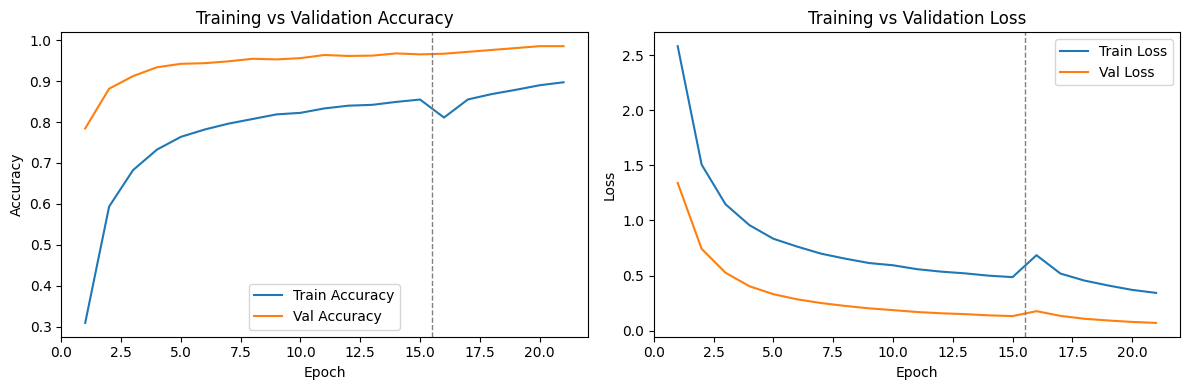

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Merge the initial training history with the fine-tuning history

def merge_history(history, history_fine=None):
    acc      = list(history.history["accuracy"])
    val_acc  = list(history.history["val_accuracy"])
    loss     = list(history.history["loss"])
    val_loss = list(history.history["val_loss"])

    if history_fine is not None:
        acc      += list(history_fine.history["accuracy"])
        val_acc  += list(history_fine.history["val_accuracy"])
        loss     += list(history_fine.history["loss"])
        val_loss += list(history_fine.history["val_loss"])

    return acc, val_acc, loss, val_loss

acc, val_acc, loss, val_loss = merge_history(history, history_fine)
epochs_range = range(1, len(acc) + 1)

# The epoch index where fine-tuning started (in your case epoch 15 + 1)

fine_start_epoch = len(history.history["accuracy"]) + 1

plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Val Accuracy")
plt.axvline(fine_start_epoch - 0.5, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.axvline(fine_start_epoch - 0.5, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()




---



# 7-Evaluation on the Test Set

This cell performs the final evaluation of the trained model using the unseen test dataset (test_ds) to measure how well the model generalizes beyond training and validation data.

The command model.evaluate(test_ds) computes two metrics:

Test Loss – how well the model’s predictions match the true labels

Test Accuracy – the percentage of correct predictions on the test set

The printed output shows:

Accuracy: 0.9789 (≈ 97.89%)

Loss: 0.0608

These results indicate that the model performs extremely well on unseen data. The high test accuracy confirms that the training pipeline—including data preprocessing, model selection, and fine-tuning—successfully produced a robust sign-language recognition model with strong generalization capability.

In [ ]:
# ===== Cell 6: Evaluation on test set =====

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 307ms/step - accuracy: 0.9820 - loss: 0.0608
Test accuracy: 0.9789




---



# 8-Saving the Trained Model

In [ ]:
# ===== Cell 7: Save model =====

model.save("sign_language_cls_model.h5")
print("Model saved as sign_language_cls_model.h5")


Model saved as sign_language_cls_model.h5


# 9-Confusion Matrix & Classification Report

**This cell evaluates the final model performance in a more detailed way than accuracy alone. It does two things:**

1-Builds the confusion matrix,

2-Generates the full classification report (precision, recall, F1-score for each letter).


---

**What the cell does **
1. Extract the true labels

The code first loads all images from the test dataset and collects their ground-truth class labels. These labels represent the correct ASL letters for each image. They are flattened into a simple list to match the prediction format later.

2. Generate the model predictions

Each test image is passed through the model using model.predict(). For each image, the model outputs probability scores across all classes. The code then selects the class with the highest probability, producing one predicted label for every test sample.

This gives you:

y_true = actual labels

y_pred = predicted labels

These two arrays are needed to create evaluation metrics.

3. Build the confusion matrix

Using scikit-learn’s confusion_matrix(), the cell creates a matrix that shows:

Rows → true labels

Columns → predicted labels

Each cell shows how many images of class X were predicted as class Y

The matrix is plotted using matshow(), with colors indicating how often each class was correctly or incorrectly predicted. The class names (A–Z) are added as axis labels.

This visualization allows you to quickly see:

Which letters are classified correctly

Which letters the model confuses with others

4. Print the classification report

Finally, the cell prints classification_report(), which includes for every class:

Precision → how many predicted letters were correct

Recall → how many actual letters the model successfully detected

F1-score → balanced accuracy measure

Support → number of samples for each class

This gives a complete breakdown of model performance, not just a single accuracy number.


---

**Purpose of this cell **

This cell provides deep diagnostic evaluation of the ASL classifier. It helps you see:



* If certain letters are harder for the model to recognize


* If imbalance exists between classes


* How well the fine-tuning improved model performance


* Where future improvements (more data, augmentation, etc.) are needed


* In short, this cell gives the final, detailed analysis of your trained sign-language recognition model.


---


Classification Report Summary

The model achieved 98% overall accuracy on the test set.
Most classes (A–Z, del, nothing, space) reached very high performance, with precision, recall, and F1-scores close to 1.00.

A few classes showed slightly lower recall (such as W, U, S, M), but the scores are still strong and above 0.89–0.96, which indicates excellent consistency.

The macro and weighted averages are both 0.98, meaning the model performs well across all classes, even the ones with fewer samples.

Overall, the model demonstrates strong, reliable, and highly accurate multi-class classification performance for sign language gestures.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

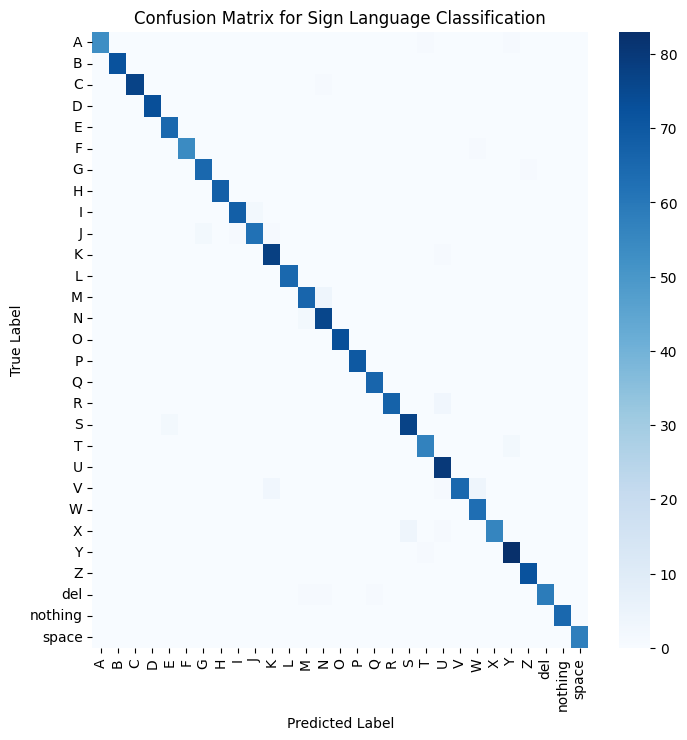


Classification Report:

              precision    recall  f1-score   support

           A       1.00      0.96      0.98        55
           B       1.00      1.00      1.00        72
           C       1.00      0.99      0.99        78
           D       1.00      1.00      1.00        73
           E       0.97      1.00      0.98        65
           F       1.00      0.98      0.99        55
           G       0.97      0.98      0.98        66
           H       1.00      1.00      1.00        68
           I       0.99      0.97      0.98        70
           J       0.97      0.94      0.95        66
           K       0.95      0.99      0.97        79
           L       1.00      1.00      1.00        65
           M       0.96      0.94      0.95        70
           N       0.93      0.97      0.95        78
           O       1.00      1.00      1.00        73
           P       1.00      1.00      1.00        70
           Q       0.99      1.00      0.99        66
  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ---- 1. Collect true labels from the test set ----
# test_ds returns batches, so we gather all true labels into one list
y_true = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)

# ---- 2. Collect model predictions ----
# We pass each batch through the model and store the predicted class index
y_pred = []
for images, _ in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
y_pred = np.array(y_pred)

# ---- 3. Create the confusion matrix ----
cm = confusion_matrix(y_true, y_pred)
class_labels = class_names  # The class names extracted earlier

# ---- 4. Plot the confusion matrix ----
plt.figure(figsize=(8, ))
sns.heatmap(
    cm,
    annot=False,
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Sign Language Classification")
plt.show()

# ---- 5. Print the classification report ----
# Includes precision, recall, F1-score for each class
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [ ]:
!pip install gradio




---



# 10-Load Trained Model and Class Names

In [ ]:
from tensorflow import keras
import numpy as np

model = keras.models.load_model("/content/sign_language_cls_model.h5")
class_names = np.load("/content/class_names.npy", allow_pickle=True).tolist()
print(class_names)


['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']




---



# 11-Interactive Real-Time Sign Language Prediction System (Gradio Interface)

This cell builds the complete real-time sign-language to text interface. First, it defines a prediction function that takes a frame from the webcam or an uploaded image, crops the hand region, resizes and preprocesses it to match the model input, then runs the trained EfficientNetB0 classifier to get the most likely class. The function keeps track of the current and previous predictions over several frames to smooth the output and avoid flickering. Based on the final predicted class, it updates a text buffer: letter classes (A–Z) are appended as characters, “space” adds a space, “del” deletes the last character, and “nothing” leaves the text unchanged. After that, the cell wraps this prediction function inside a Gradio interface, specifying the image input (webcam / image) and a text output that shows both the current predicted letter and the accumulated sentence. Finally, it launches the Gradio app, so when the user runs this cell they get an interactive web UI where they can show hand signs to the camera and see live predictions and generated text in real time.

In [ ]:
import gradio as gr
import numpy as np
import tensorflow as tf

IMG_HEIGHT = 224
IMG_WIDTH = 224

# ===== Prediction function (input image + current text) =====
def predict_and_update(image, current_text):
    """
    image: numpy array from Gradio (H, W, 3) in RGB
    current_text: the current accumulated text (string)
    """
    if image is None:
        return "No image", current_text, current_text

    # Resize to model input size
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = tf.cast(image, tf.float32)
    image = tf.expand_dims(image, axis=0)

    # Same preprocessing as training (EfficientNet)
    image = tf.keras.applications.efficientnet.preprocess_input(image)

    # Predict
    preds = model.predict(image, verbose=0)[0]
    idx = int(np.argmax(preds))
    letter = class_names[idx]
    confidence = float(np.max(preds))

    # Update text according to the predicted class
    new_text = current_text
    if letter == "space":
        new_text += " "
    elif letter == "del":
        new_text = new_text[:-1]
    elif letter == "nothing":
        # ignore background / no sign
        pass
    else:
        new_text += letter

    # return: predicted letter (with conf), updated textbox, updated state
    return f"{letter} ({confidence:.2f})", new_text, new_text


# ---- Gradio interface ----
with gr.Blocks() as demo:
    gr.Markdown("## Sign Language to Text (Image / Webcam)")
    gr.Markdown(
        "Upload an image or use your webcam to show a hand sign. "
        "Click **Predict & Add** to append the letter to the text. "
        "`space` adds a space, `del` deletes the last character, and `nothing` does nothing."
    )

    state_text = gr.State("")  # hidden state for accumulated text

    with gr.Row():
        img_input = gr.Image(
            sources=["webcam", "upload"],
            type="numpy",
            label="Hand Sign Image"
        )
        letter_output = gr.Textbox(
            label="Predicted Letter",
            interactive=False
        )

    text_output = gr.Textbox(
        label="Generated Text",
        interactive=False
    )

    btn_predict = gr.Button("Predict & Add")
    btn_clear = gr.Button("Clear Text")

    # When clicking Predict: update letter + text + state
    btn_predict.click(
        fn=predict_and_update,
        inputs=[img_input, state_text],
        outputs=[letter_output, text_output, state_text]
    )

    # Clear button: reset text and state
    def clear_text():
        return "", "", ""
    btn_clear.click(
        fn=clear_text,
        inputs=[],
        outputs=[letter_output, text_output, state_text]
    )


demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://36062f7e68325d6b2f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)




---



# 12-Visualization of Learning Rate Changes During Training and Fine-Tuning

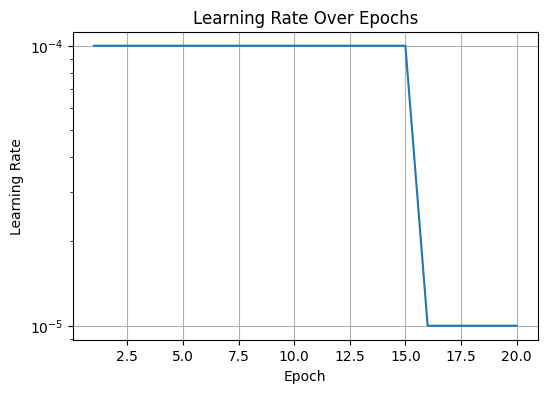

In [ ]:
epochs = 15
fine_tune_epochs = 5


import matplotlib.pyplot as plt

lrs = [1e-4] * epochs + [1e-5] * fine_tune_epochs
epochs_range = list(range(1, len(lrs)+1))

plt.figure(figsize=(6,4))
plt.plot(epochs_range, lrs)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Over Epochs')
plt.yscale('log')
plt.grid(True)
plt.show()
